# Лучший вариант

In [ ]:
!pip install hungarian-algorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from hungarian_algorithm import algorithm

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from scipy import ndimage
from google.colab import drive
from os import listdir
from os.path import isfile, join
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

In [ ]:
drive.mount("/content/gdrive", force_remount=True)
data_path = "/content/gdrive/MyDrive/Курсовая/textures/"


Mounted at /content/gdrive


# Pipeline обработки и выделения пятен

In [ ]:
textures = [f for f in listdir("/content/gdrive/MyDrive/Курсовая/textures/")]
for texture in textures:
  pl_num = int(texture[:texture.find('_')])
  img = cv.imread(data_path + texture, cv.IMREAD_UNCHANGED)
  gr_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  background = img[:, :, 3] > 0
  lap_gaus = ndimage.laplace(ndimage.gaussian_filter(gr_img, sigma=2))
  _ = ndimage.gaussian_filter(lap_gaus, sigma=1)
  _, spots = cv.threshold(_, 200 ,255, cv.THRESH_BINARY)
  res = np.empty((1024, 144))
  res[:, :144] = gr_img
  res[:, 144:] = spots * background
  cv.imwrite('/content/gdrive/MyDrive/Курсовая/extracted/' + str(pl_num) + '/' + texture , res)

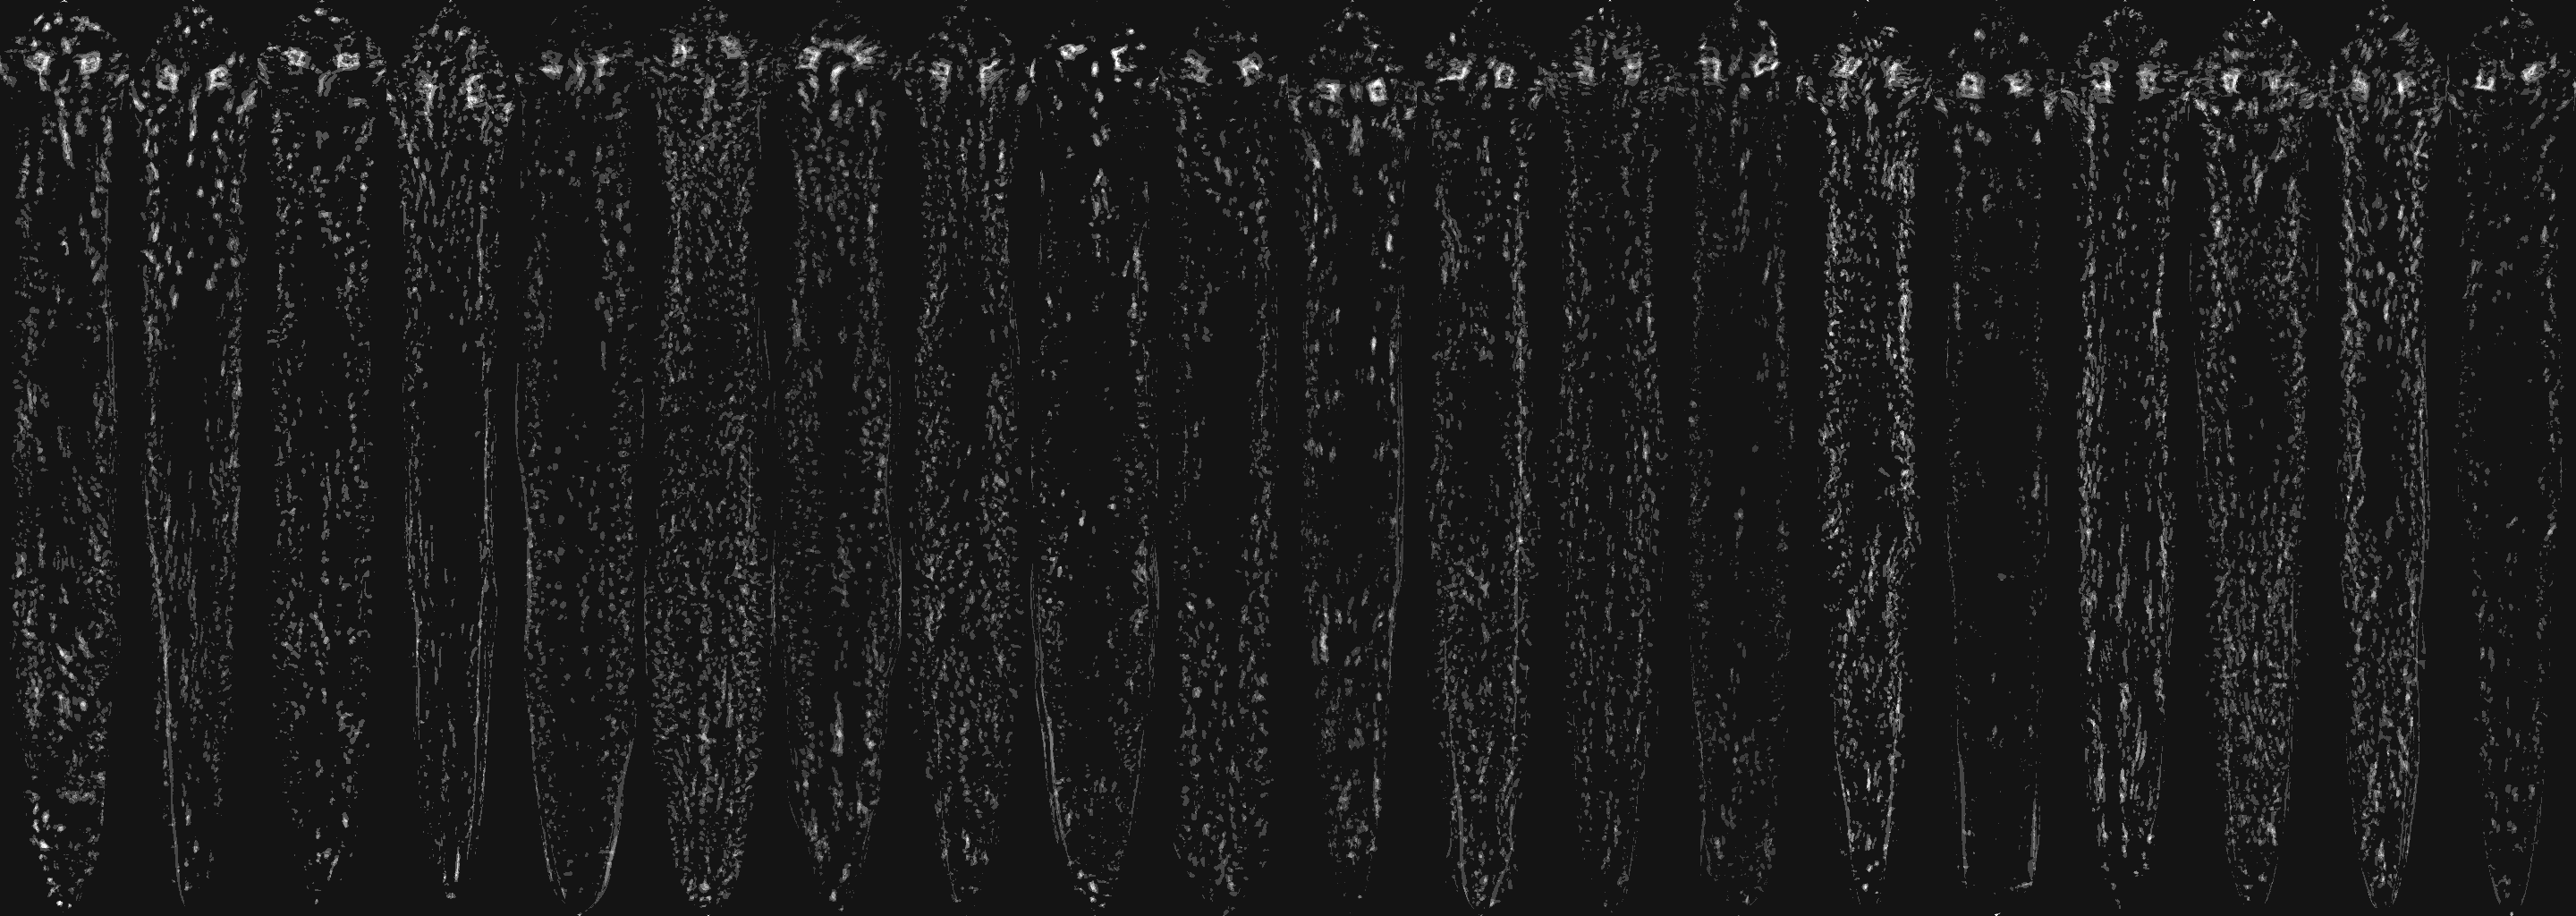

In [ ]:
#все черви до отсечения головы
all = []
for i in range(1, 21):
  t = ["/content/gdrive/MyDrive/Курсовая/processed/" + str(i) + '/' + f for f in listdir("/content/gdrive/MyDrive/Курсовая/processed/" + str(i)) if f[3:5] == '00']
  curr = np.zeros((1024, 144))
  for a in t:
    curr += cv.imread(a, cv.IMREAD_GRAYSCALE)[:, 144:] // 255
  all.append(curr * 255 // curr.max() + 20)

cv2_imshow(np.concatenate(all, axis=1))

Проводим эксперименты на 3х особях: 1,

у первой есть три характерных пятнышка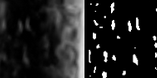

# Блок констант

In [ ]:
MIN_AREA = 5
INF = 1e8
TOTAL_ENTITIES = 20
ALL_PLANARIAS = []
for i in range(1, TOTAL_ENTITIES + 1):
  if len(str(i)) == 1:
    ALL_PLANARIAS.append('0' + str(i))
  else:
    ALL_PLANARIAS.append(str(i))

In [ ]:
#Выделение "паспорта"
curr_path = '/content/gdrive/MyDrive/Курсовая/processed/1'
pl1 = [f for f in listdir("/content/gdrive/MyDrive/Курсовая/textures/") if (f[0] == '0' and f[1] == '1')]
len(pl1)

10

одному пятну может быть сопоставлено несколько или ни одноного.
Учитываем смещение центра масс, размер(совокупный)

может быть такое, что наоборот, несколько пятен в нашей планарии соответсвует одному пятну в другой. Надо сразу для обеих лосс считать, составлять симметричную процедуру

вырезать и накладывать конкретные пятна ???
делать растяжение ???

устройчиво расположение и форма

возращать вероятности???

если для каждого пятна известно, какие ему мог

решить для одного???
выбор кол-ва пятен
для кол-ва выбор оптимума

сделаем сначала в рамках одного дня

Стабильны по оси Х, по У есть смещение.


https://pypi.org/project/PuLP/ - для линейного программирования

https://cvxopt.org/ - для выпуклой оптимизации

https://docs.scipy.org/doc/scipy/tutorial/optimize.html - разное по оптимизации


In [ ]:
res = np.empty((1024, 288))
planarias = []
for w, texture in enumerate(pl1):
  img = cv.imread(data_path + texture, cv.IMREAD_UNCHANGED)
  gr_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  background = img[:, :, 3] > 0
  lap_gaus = ndimage.laplace(ndimage.gaussian_filter(gr_img, sigma=2))
  _ = ndimage.gaussian_filter(lap_gaus, sigma=1)
  _, spots = cv.threshold(_, 200 ,255, cv.THRESH_BINARY)

  cc = cv.connectedComponentsWithStats(spots, 8, cv.CV_32S)
  total_cc = cc[0]
  labels = cc[1]
  stats = cc[2]
  centroids = cc[3]

  good_cc = []
  zeros = np.zeros((1024, 144))
  good_centroids = []
  good_stats = []
  for i in range(total_cc):
    a = (labels == i)
    b = a * background
    if #здесь поменялось np.array_equal(a, b) and stats[i, cv.CC_STAT_AREA] > MIN_AREA:# and stats[i, cv.CC_STAT_TOP] < 30:
      good_cc.append(i)
      good_centroids.append(centroids[i])
      good_stats.append(stats[i])


  labels_good = np.isin(np.array(labels), np.array(good_cc)) * labels

  planarias.append({'cc_names': good_cc,
                    'labels': labels_good,
                    'centroids': good_centroids,
                    'stats': good_stats})

  areas = stats[good_cc, cv.CC_STAT_AREA]
  args = np.argsort(areas)[::-1]
  sorted_areas = np.sort(areas)[::-1]
  #for i, area in enumerate(sorted_areas[100:]):
  #    labels_good[labels_good == args[i]] = 0
  #res[:, 144 * (w): 144 * (w + 1)] = (labels_good != 0).astype(int) * 255

# Функция, которая обрабатывает картинки одной планарии и возвращает список ее пятен

Вход: номер планарии в виде строки из двух цифр

Выход: словарь, в котором ключ - номер дня, значение - список структур планарий

In [ ]:
def process_planaria(pl_str):
  #список файлов с исходными изображениями планарий
  pl = [f for f in listdir("/content/gdrive/MyDrive/Курсовая/textures/") if f[0:2] == pl_str]

  #возвращаем словарь, в котором индекс - номер дня, ключ - структура планарии
  ans = {}

  for w, texture in enumerate(pl):
    img = cv.imread(data_path + texture, cv.IMREAD_UNCHANGED)
    gr_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    background = ~img[:, :, 3] > 0
    lap_gaus = ndimage.laplace(ndimage.gaussian_filter(gr_img, sigma=2))
    _ = ndimage.gaussian_filter(lap_gaus, sigma=1)
    _, spots = cv.threshold(_, 200 ,255, cv.THRESH_BINARY)

    cc = cv.connectedComponentsWithStats(spots, 8, cv.CV_32S)
    total_cc = cc[0]
    labels = cc[1]
    stats = cc[2]
    centroids = cc[3]

    good_cc = []
    zeros = np.zeros((1024, 144))
    good_centroids = []
    good_stats = []
    for i in range(total_cc):
      a = (labels == i)
      b = a * background
      if b.sum() == 0 and stats[i, cv.CC_STAT_AREA] > MIN_AREA:
        good_cc.append(i)
        good_centroids.append(centroids[i])
        good_stats.append(stats[i])


    labels_good = np.isin(np.array(labels), np.array(good_cc)) * labels
    good_cc = np.array(good_cc)
    good_centroids = np.array(good_centroids)
    good_stats = np.array(good_stats)
    day_number = int(texture[3:5])
    if day_number in ans.keys():
      ans[day_number] += [
                      {'cc_names': good_cc,
                      'labels': labels_good,
                      'centroids': good_centroids,
                      'stats': good_stats}]
    else:
      ans[day_number] = [
                      {'cc_names': good_cc,
                      'labels': labels_good,
                      'centroids': good_centroids,
                      'stats': good_stats}]
  return ans

# Посмотрим на всех планарий

Есть идея попробовать задать "важность" пятна, и оставлять только фиксированно количество важных пятен

Сделаем сводку всех планарий, чтобы выбрать тех, которые получились хорошо, и на них уже проводить эксперимент

In [ ]:
data_path

'/content/gdrive/MyDrive/Курсовая/textures/'

In [ ]:
for num_pl in ALL_PLANARIAS:
  pl = process_planaria(num_pl)
  merged = np.zeros((1024 * len(pl.keys()), 144 * 8))
  for i, day in enumerate(pl.keys()):
    for j, k in enumerate(pl[day]):
      merged[i * 1024 : (i + 1) * 1024, j * 144 : (j + 1) * 144] = (k['labels'] > 0) * 255
  cv.imwrite('/content/gdrive/MyDrive/Курсовая/processed/' + num_pl + '.png', merged)

# Пробуем найти линейное преобразование по длине

**Структура планарии**

Словарь, соотвествующий одному изображению планарии, который содержит:

1.   'cc_names' - список чисел, обозначающий какие есть номера пятен
2.   'labels' - np.array, в котором числу в ячейке соответствует номер пятна, в которому он относится
3.    'centroids' - матрица, в которой в каждой строке записана пара чисел, соотвествующуя центру пятна (снача координата по х, потом по у, левый верхний угол - (0, 0))
4.     'stats' - матрица со стастиками, обращение к которой происходит следующим образом: stats[label, COLUMN]



**Требуется свойство эквивариантности**

**Функция для определения сходства**
Вход: два структуры планарии

Выход: число (мера того, насколько планарии отличаются)(чем меньше, тем более похожие)

*Вроде бы получилась симметричной, по типу расстояния*

Свойства:

compare(a, b) = compare(b, a)

compare(a, a) = 0

Еще надо отдать больший вес значениям в хвосте планарии по сравнению со значениями около головы

В принципе можно попробовать привести все пятна в какой-то стандартной толщине

Или пробовать выделять характерный рисунок из графов, перевести граф в какое-то пространство эмбеддингов
Взять в качестве узла характеристики пятна, в качестве ребер - расстояния между ними

In [ ]:
def compare(plan1, plan2):
  dist = np.zeros((len(plan1['cc_names']), len(plan2['cc_names']))) #матрица расстояний между пятнами
  for i in range(len(plan1['cc_names'])):
    for j in range(len(plan2['cc_names'])):
      #центроида отвечает за расположение пятна
      c1 = plan1['centroids'][i]
      c2 = plan2['centroids'][j]
      #bounding box и площадь за форму
      w1 = plan1['stats'][i, cv.CC_STAT_WIDTH]
      w2 = plan2['stats'][j, cv.CC_STAT_WIDTH]
      h1 = plan1['stats'][i, cv.CC_STAT_HEIGHT]
      h2 = plan2['stats'][j, cv.CC_STAT_HEIGHT]
      area1 = plan1['stats'][i, cv.CC_STAT_AREA]
      area2 = plan2['stats'][j, cv.CC_STAT_AREA]

      coeff = 5 #насколько сильнее штрафуем за несоотвествие по y
      dist[i][j] = (coeff * (c1[0] - c2[0]) ** 2 + 2 *(c1[1] - c2[1]) ** 2) ** 0.5 + abs(w1 - w2) + abs(h1 - h2) + abs(area1 - area2)

  row_ind, col_ind = linear_sum_assignment(dist) #решаем задачу о назначениях с данной матрицей расстояний
  return dist[row_ind, col_ind].sum(), row_ind, col_ind

In [ ]:

def compare_old(plan1, plan2):
  dist = np.zeros((len(plan1['cc_names']), len(plan2['cc_names']))) #матрица расстояний между пятнами
  for i in range(len(plan1['cc_names'])):
    for j in range(len(plan2['cc_names'])):
      c1 = plan1['centroids'][i]
      c2 = plan2['centroids'][j]
      w1 = plan1['labels'][i, cv.CC_STAT_WIDTH]
      w2 = plan2['labels'][j, cv.CC_STAT_WIDTH]
      h1 = plan1['labels'][i, cv.CC_STAT_HEIGHT]
      h2 = plan2['labels'][j, cv.CC_STAT_HEIGHT]
      dist[i][j] = ((c1[0] - c2[0]) ** 2 + 2 *(c1[1] - c2[1]) ** 2) ** 0.5 + abs(w1 - w2) + abs(h1 - h2)

  row_ind, col_ind = linear_sum_assignment(dist) #решаем задачу о назначениях с данной матрицей расстояний
  return dist[row_ind, col_ind].sum(), row_ind, col_ind

Пробуем решить задачу перебором коэффициента

Попробуем посмотреть как выглядят сжатые и несжатые планарии
(Сверху будут пустоты, которые у исходной планарии были заполнены "глазами")

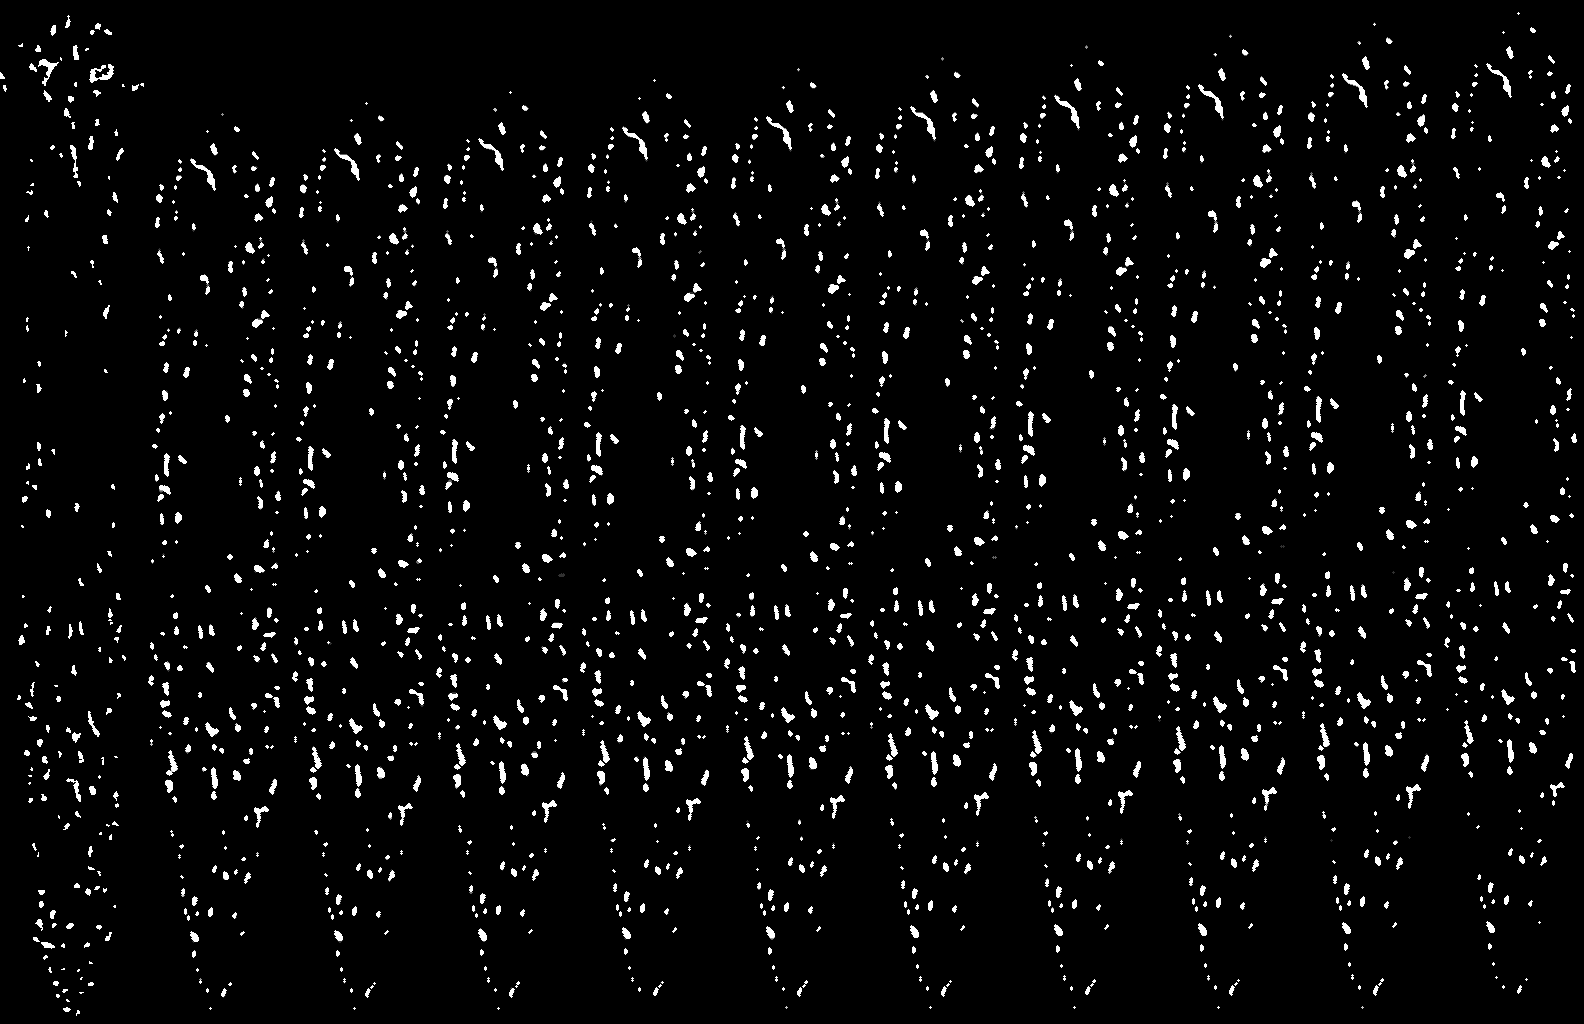

In [ ]:
alphas = np.linspace(0.9, 1, num=10)
res = [pl[0]['labels'].astype('uint8')]
for i, alpha in enumerate(alphas):
  new_len = int(np.floor(1024 * alpha))
  squeezed = np.zeros((1024, 144))
  zoom = ndimage.zoom(pl[5]['labels'], (alpha, 1))
  squeezed[(1024 - zoom.shape[0]):] = zoom
  squeezed = cv.morphologyEx(squeezed, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))
  res.append(squeezed)

cv2_imshow(np.concatenate(res, axis=1) * 50)

Хотим проверить гипотезу о том, что коэффициент линейного преобразования увеличивается пропорционально суткам

Гипотеза отвергнута по биологическим причинам

In [ ]:
pl = process_planaria('02')
a = []
for i in pl[0]:
  a.append(i['labels'])
cv2_imshow(np.concatenate(a, axis=1) * 50)

В принципе может и не нужно особо заморачиваться с этим линейныйм преобразованием, потому что даже в рамках одного дня группы пятен гуляют туда-сюда. Можно просто перебрать несколько значений и выбрать оптимальное

In [ ]:
#Посмотрим на линейные преобразования для всех дней для всех планарий
alphas = np.linspace(0.9, 1, num=10)
for i in range(20):
  num_pl = str(i)
  if len(num_pl) == 1:
    num_pl = '0' + num_pl
  pl = process_planaria(num_pl)
  days = list(pl.keys())
  for j, day in enumerate(days[1:]):
    res = [pl[0][0]['labels'].astype('uint8')]
    for k, alpha in enumerate(alphas):
      squeezed = np.zeros((1024, 144))
      zoom = ndimage.zoom(pl[day][0]['labels'], (alpha, 1))
      squeezed[(1024 - zoom.shape[0]):] = zoom
      squeezed = cv.morphologyEx(squeezed, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))
      res.append(squeezed)
    cv.imwrite('/content/gdrive/MyDrive/Курсовая/linear/' + num_pl+ '_' + str(day)+'.png', np.concatenate(res, axis=1) * 50)

Сранение после линейного преобразования

In [ ]:
alphas = np.linspace(0.9, 1, num=10)
res = np.zeros_like(alphas)
for i, alpha in enumerate(alphas):
  #сжимаем планарию с хвоста(хвост - неподвижная точка)
  squeezed = np.zeros((1024, 144))
  zoom = ndimage.zoom(pl[5]['labels'], (alpha, 1))
  squeezed[(1024 - zoom.shape[0]):] = zoom

  #создадим маску, чтобы не учитывать голову планарий
  mask = np.zeros_like(squeezed)
  mask[(1024 - zoom.shape[0]):] = np.ones_like(zoom)

  #сделаем морфологическую операцию чтобы убрать артефакты сжатия
  squeezed = cv.morphologyEx(squeezed, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))

  #создадим структуру планарии
  cc = cv.connectedComponentsWithStats(squeezed.astype('uint8'), 8, cv.CV_32S)
  total_cc = cc[0]
  labels = cc[1]
  stats = cc[2]
  centroids = cc[3]
  curr_pl = {'cc_names': list(range(total_cc)),
             'labels': labels,
             'centroids': centroids,
             'stats': stats}

  #сравним
  res[i] = compare(pl[0], curr_pl)[0]

print(res)



In [ ]:
---------------------------------------------------------------------------------------------------------

# Если с функцией сравнения не получается, попробуем выделить признаки

*Признаки будут неупорядоченными, ну или точнее не строго упорядоченными, так как змеевидный порядок обхода сохраняется, но пятна могут флуктуировать*

# Для того, чтобы выделить признаки, надо сначала отобрать фиксированное количество пятен с каждой

Уберем голову с фотографий нулевого дня

А еще узор, который появляется на отрощенной части головы, не совпадает с тем, который был там раньше, поэтому туда смотреть может быть даже вредно

Пятна с хвоста более важные, чем с головы

Попробуем сначала наивно

Будет нормализовывать признаки, чтобы контролировать их значимость

In [ ]:
#посчитаем среднее и дисперсию
areas = []
for pl_num in ALL_PLANARIAS:
  pl = process_planaria(pl_num)
  for day in pl.keys():
    for i in pl[day]:
      areas.extend(list(i['stats'][:, cv.CC_STAT_AREA]))
areas = np.array(areas)
area_mean = areas.mean()
area_std = areas.std()

In [ ]:
def extract_50spots(planaria):
  '''
  Вход: структура планарии
  Выход: структура планарии, в которой оставлены 50 самых больших по площади пятен
  '''
  if len(planaria['cc_names']) < 50:
    return None
  importance = np.empty_like(planaria['cc_names'])
  for i, spot in enumerate(planaria['cc_names']):
    importance[i] = (planaria['stats'][i, cv.CC_STAT_AREA] - area_mean) / area_std + planaria['centroids'][i][1] / 1024
  args = np.argsort(importance)[::-1][:50]
  mask = np.isin(planaria['labels'], planaria['cc_names'][args])
  return {'cc_names': planaria['cc_names'][args],
          'labels': planaria['labels'] * mask,
          'centroids': planaria['centroids'][args],
          'stats': planaria['stats'][args]
  }

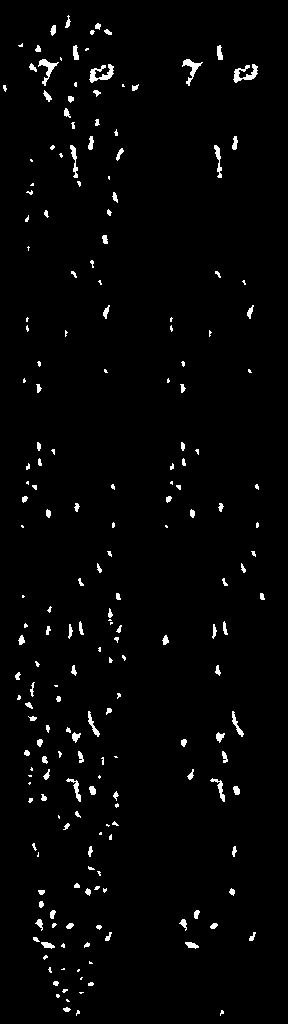

In [ ]:
pl = process_planaria('01')
cv2_imshow(np.concatenate([pl[0][0]['labels'], extract_50spots(pl[0][0])['labels']], axis=1) * 50)

Давайте попробуем выделить паспорт

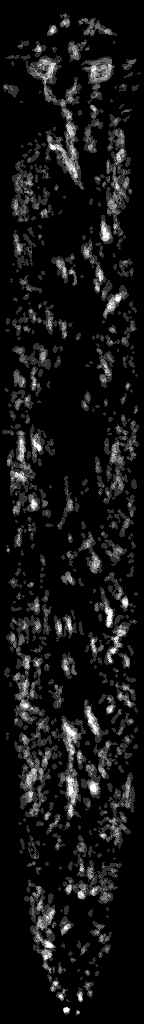

In [ ]:
res = np.zeros((1024, 144))
alphas = np.linspace(0.9, 1, num=10)
pl = process_planaria('01')
for i in pl[0]:
  res += (i['labels'] > 0)
for day in list(pl.keys())[1:]:
  intersection = np.zeros_like(alphas)
  for j in range(len(pl[day])):
    for i, alpha in enumerate(alphas):
      squeezed = np.zeros((1024, 144))
      zoom = ndimage.zoom(pl[day][j]['labels'], (alpha, 1))
      squeezed[(1024 - zoom.shape[0]):] = zoom
      mask = np.zeros_like(squeezed)
      mask[(1024 - zoom.shape[0]):] = np.ones_like(zoom)
      squeezed = cv.morphologyEx(squeezed, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))
      intersection[i] = (((res > 0) * mask) * (squeezed > 0)).sum()
    best_alpha = alphas[np.argmax(intersection)]
    squeezed = np.zeros((1024, 144))
    zoom = ndimage.zoom(pl[day][j]['labels'], (best_alpha, 1))
    squeezed[(1024 - zoom.shape[0]):] = zoom
    squeezed = cv.morphologyEx(squeezed, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))
    res += (squeezed > 0)
cv2_imshow(res * 50)

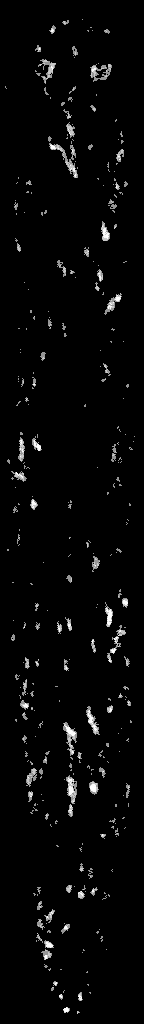

In [ ]:
cv2_imshow(res * (res > 2) * 50)

In [ ]:
from scipy.special import softmax


all = []
for num_pl in ALL_PLANARIAS:
  print(num_pl)
  res = np.zeros((1024, 144))
  alphas = np.linspace(0.9, 1, num=10)
  pl = process_planaria(num_pl)
  days = sorted(pl.keys())
  print(days)
  for i in pl[days[0]]:
    res += (i['labels'] > 0)
  for day in days[1:]:
    intersection = np.zeros_like(alphas)
    for j in range(len(pl[day])):
      for i, alpha in enumerate(alphas):
        squeezed = np.zeros((1024, 144))
        zoom = ndimage.zoom(pl[day][j]['labels'], (alpha, 1))
        squeezed[(1024 - zoom.shape[0]):] = zoom
        mask = np.zeros_like(squeezed)
        mask[(1024 - zoom.shape[0]):] = np.ones_like(zoom)
        squeezed = cv.morphologyEx(squeezed, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))
        intersection[i] = (((res > 0) * mask) * (squeezed > 0)).sum()
      best_alpha = alphas[np.argmax(intersection)]
      squeezed = np.zeros((1024, 144))
      zoom = ndimage.zoom(pl[day][j]['labels'], (best_alpha, 1))
      squeezed[(1024 - zoom.shape[0]):] = zoom
      squeezed = cv.morphologyEx(squeezed, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))
      res += (squeezed > 0)
  all.append(softmax(res))

cv2_imshow(np.concatenate(all, axis=1) * 255)

In [ ]:
GOOD_PL = ['0' + str(i) for i in range(2, 10)] + [str(i) for i in range(12, 16)] + [str(i) for i in range(18, 21)]


In [ ]:
all = []
for num_pl in ALL_PLANARIAS:
  print(num_pl)
  res = np.zeros((1024, 144))
  alphas = np.linspace(0.9, 1, num=10)
  pl = process_planaria(num_pl)
  days = sorted(pl.keys())
  print(days)
  for i in pl[days[0]]:
    res += (i['labels'] > 0)
  for day in days[1:]:
    intersection = np.zeros_like(alphas)
    for j in range(len(pl[day])):
      for i, alpha in enumerate(alphas):
        squeezed = np.zeros((1024, 144))
        zoom = ndimage.zoom(pl[day][j]['labels'], (alpha, 1))
        squeezed[(1024 - zoom.shape[0]):] = zoom
        mask = np.zeros_like(squeezed)
        mask[(1024 - zoom.shape[0]):] = np.ones_like(zoom)
        squeezed = cv.morphologyEx(squeezed, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))
        intersection[i] = (((res > 0) * mask) * (squeezed > 0)).sum()
      best_alpha = alphas[np.argmax(intersection)]
      squeezed = np.zeros((1024, 144))
      zoom = ndimage.zoom(pl[day][j]['labels'], (best_alpha, 1))
      squeezed[(1024 - zoom.shape[0]):] = zoom
      squeezed = cv.morphologyEx(squeezed, cv.MORPH_OPEN, cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3)))
      res += (squeezed > 0)
  all.append(softmax(res))

In [ ]:
all[0].max()

0.014025117429280797

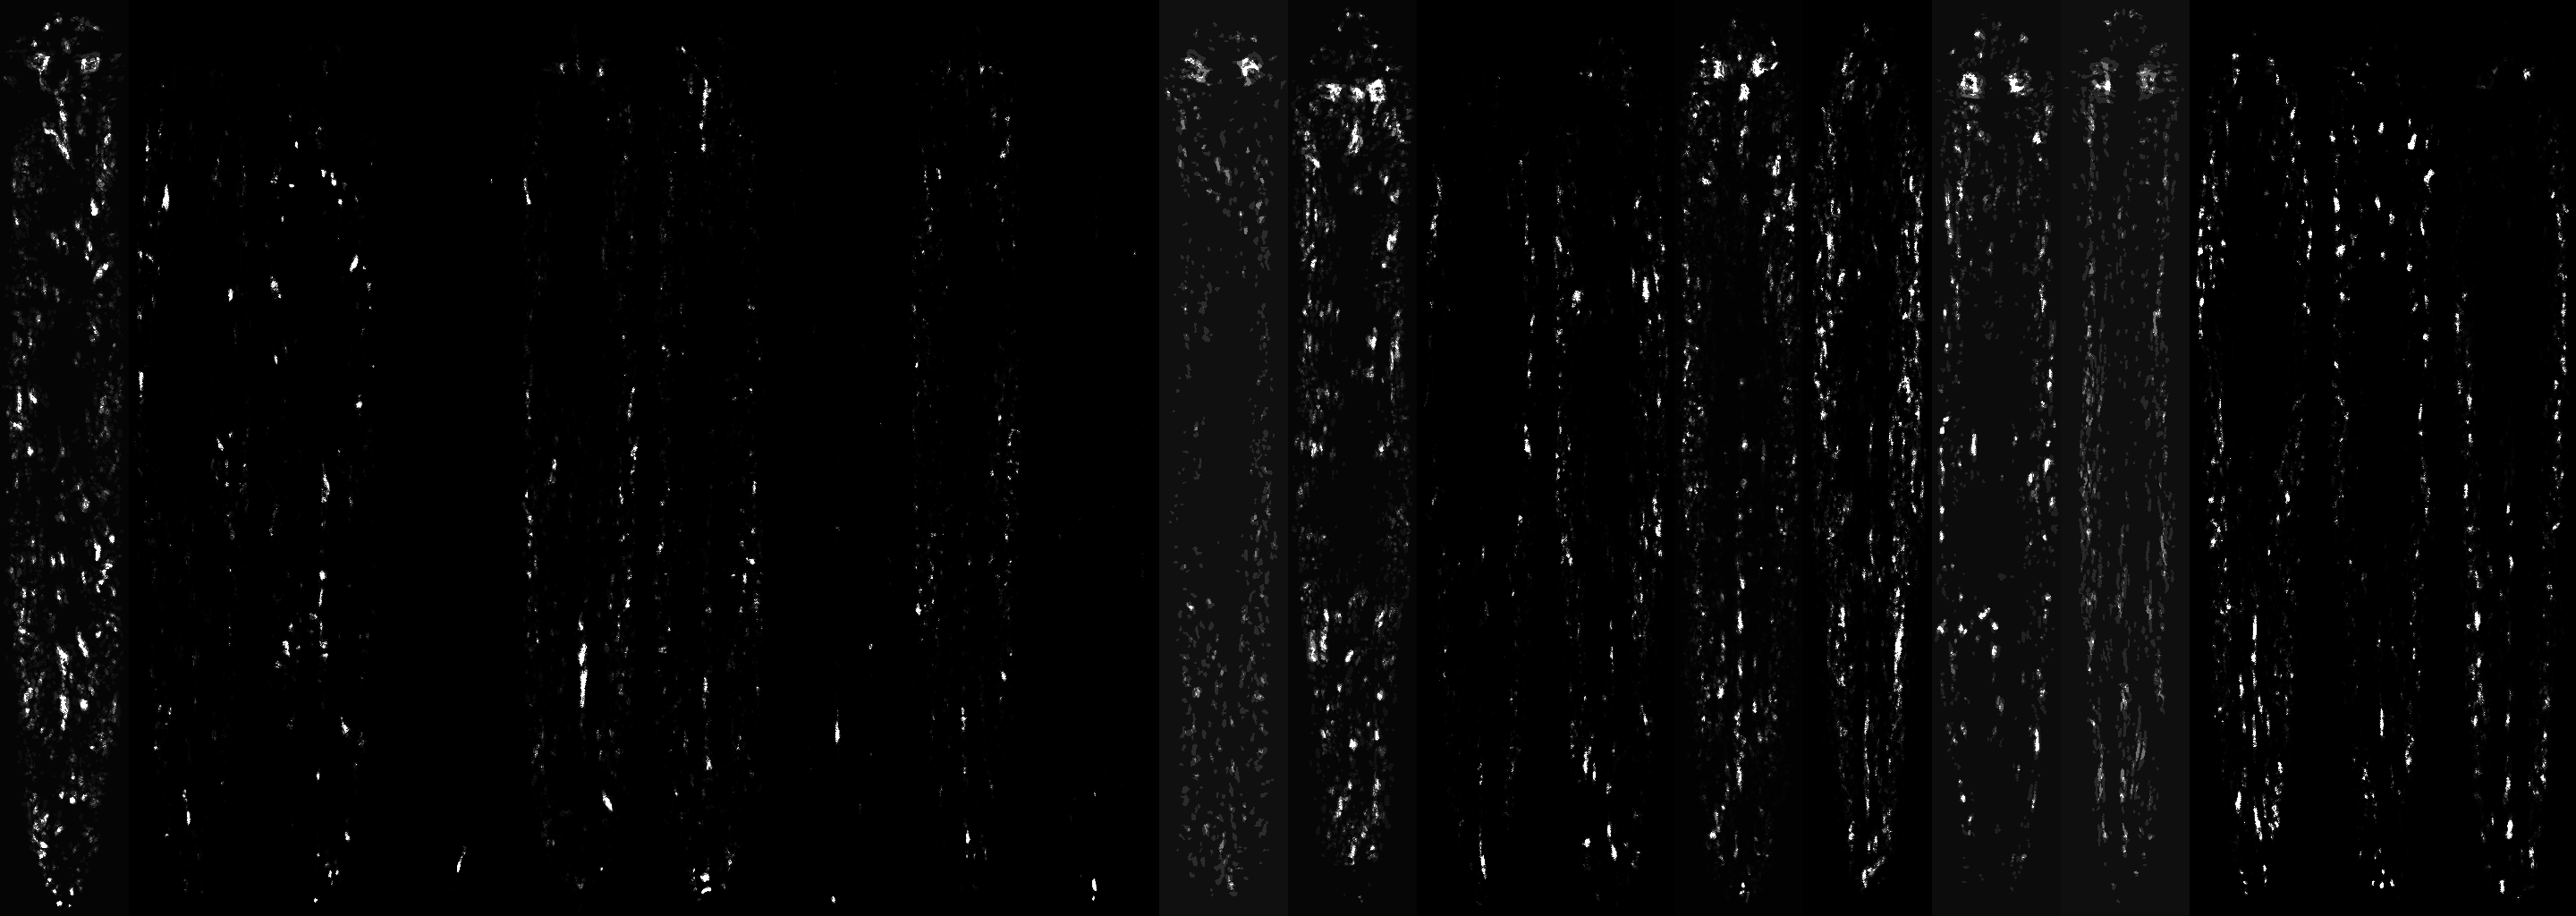

In [ ]:
cv2_imshow(np.concatenate(all, axis=1) * 3000000)

In [ ]:
inner = []
outer = []

for num_pl in ALL_PLANARIAS:
  pl = process_planaria(num_pl)
  days = sorted(pl.keys())
  for day in days[1:]:
    for j in pl[day]:
      curr = j['labels'] > 0

      for i,test in enumerate(ALL_PLANARIAS):
        res = (all[i] * curr).sum()
        if test == num_pl:
          inner.append(res)
        else:
          outer.append(res)

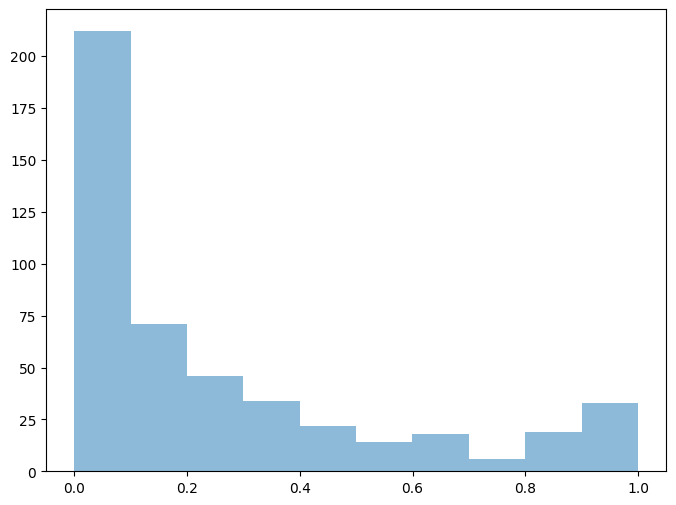

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(inner, alpha=0.5)


plt.show()


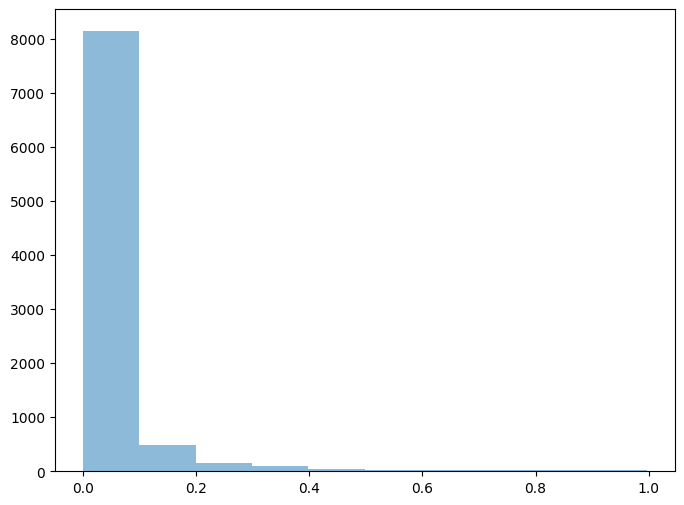

In [ ]:
plt.figure(figsize=(8, 6))

plt.hist(outer, alpha=0.5)

plt.show()

In [ ]:
s_true = 0
s_false = 0

for num_pl in ALL_PLANARIAS:
  pl = process_planaria(num_pl)
  days = sorted(pl.keys())
  for day in days[1:]:
    for j in pl[day]:
      curr = j['labels'] > 0
      probs = np.zeros(20)
      for i,test in enumerate(ALL_PLANARIAS):
        res = (all[i] * curr).sum()
        probs[i] = res
      if ALL_PLANARIAS[probs.argmax()] == num_pl:
        s_true += 1
      else:
        s_false += 1

print(s_true, s_false)

182 293


#Хочется попробовать сделать что-нибудь на графах, так как узор скорее является топологической характеристикой

# Попробуем научится отличать двух планарий (1 и 11)

In [ ]:
pl1 = process_planaria('01')
pl11 = process_planaria('11')

NameError: ignored

In [ ]:
#одна и та же особь до отсечения головы
print("Планария 1: ", compare(pl1[0][0], pl1[0][1])[0])
print("Планария 11: ", compare(pl11[0][0], pl11[0][1])[0])

Планария 1:  8050.454226217069
Планария 11:  4764.788463181858


In [ ]:
#разные особи в один день
print("Планария 1 vs 11: ", compare(pl1[0][0], pl11[0][0])[0])
print("Планария 11 vs 1: ", compare(pl11[0][0], pl1[0][0])[0])

Планария 1 vs 11:  22169.32420355332
Планария 11 vs 1:  22169.32420355332


Попробуем посчитать типичные значения для внутриклассового и межклассового расстояния (пока что без линейного смещения)

Попробуем обучить веса признаков

У нас есть два класса: одна и та же особь, и разная особь. По сути обучаем классификатор на признаках, взятых как различие между пятнами
Опять таки получается, что нужно выделить фиксированное количество пятен

Для пофикшеной функции сравнения:

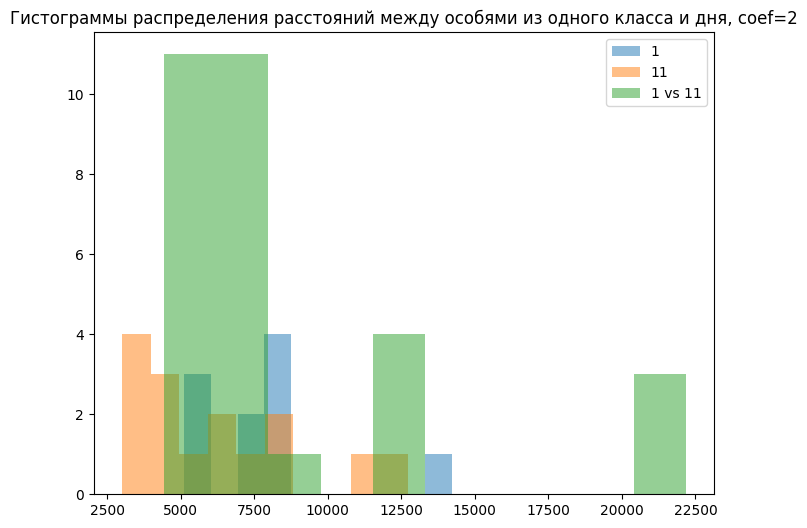

In [ ]:
pl1 = process_planaria('01')
pl11 = process_planaria('11')

#для первой планарии
distances1 = []
for i in range(len(pl1[0])):
  for j in range(i + 1, len(pl1[0])):
    distances1.append(compare(pl1[0][i], pl1[0][j])[0])

#для 11 планарии
distances11 = []
for i in range(len(pl11[0])):
  for j in range(i + 1, len(pl11[0])):
    distances11.append(compare(pl11[0][i], pl11[0][j])[0])

#для особей из разных классов
distances1_11 = []
for i in range(len(pl1[0])):
  for j in range(len(pl11[0])):
    distances1_11.append(compare(pl1[0][i], pl11[0][j])[0])

plt.figure(figsize=(8, 6))
plt.title("Гистограммы распределения расстояний между особями из одного класса и дня, coef=2")
plt.hist(distances1, label="1", alpha=0.5)
plt.hist(distances11, label="11", alpha=0.5)
plt.hist(distances1_11, label="1 vs 11", alpha=0.5)
plt.legend()
plt.show()

Для новой версии функции потерь:

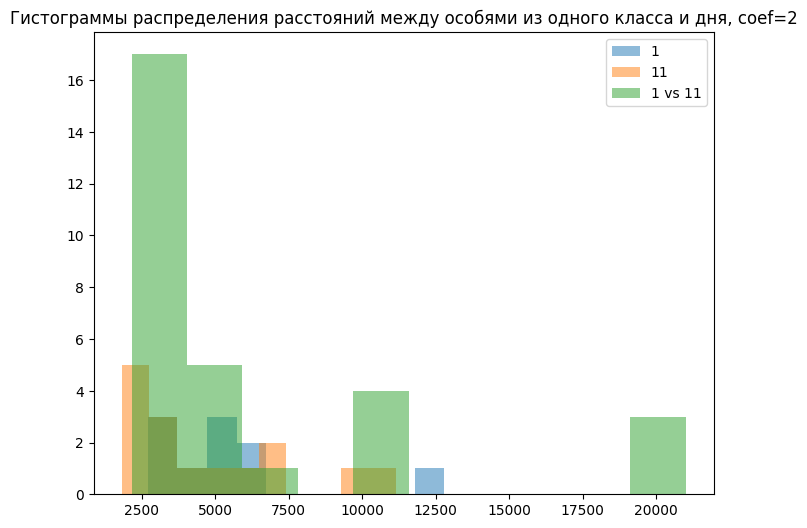

In [ ]:
#для первой планарии
distances1 = []
for i in range(len(pl1[0])):
  for j in range(i + 1, len(pl1[0])):
    distances1.append(compare(pl1[0][i], pl1[0][j])[0])

#для 11 планарии
distances11 = []
for i in range(len(pl11[0])):
  for j in range(i + 1, len(pl11[0])):
    distances11.append(compare(pl11[0][i], pl11[0][j])[0])

#для особей из разных классов
distances1_11 = []
for i in range(len(pl1[0])):
  for j in range(len(pl11[0])):
    distances1_11.append(compare(pl1[0][i], pl11[0][j])[0])

plt.figure(figsize=(8, 6))
plt.title("Гистограммы распределения расстояний между особями из одного класса и дня, coef=2")
plt.hist(distances1, label="1", alpha=0.5)
plt.hist(distances11, label="11", alpha=0.5)
plt.hist(distances1_11, label="1 vs 11", alpha=0.5)
plt.legend()
plt.show()

Это я первой версии функции потерь

In [ ]:
#для первой планарии

distances1 = []

for i in range(len(pl1[0])):
  for j in range(i + 1, len(pl1[0])):
    distances1.append(compare(pl1[0][i], pl1[0][j])[0])

In [ ]:
#для 11 планарии
distances11 = []

for i in range(len(pl11[0])):
  for j in range(i + 1, len(pl11[0])):
    distances11.append(compare(pl11[0][i], pl11[0][j])[0])

In [ ]:
#для особей из разных классов

distances1_11 = []

for i in range(len(pl1[0])):
  for j in range(len(pl11[0])):
    distances1_11.append(compare(pl1[0][i], pl11[0][j])[0])

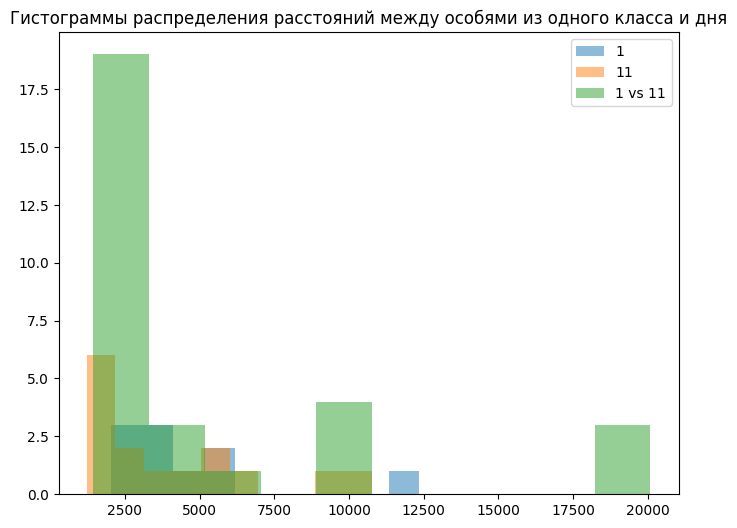

In [ ]:
plt.figure(figsize=(8, 6))

plt.title("Гистограммы распределения расстояний между особями из одного класса и дня")
plt.hist(distances1, label="1", alpha=0.5)
plt.hist(distances11, label="11", alpha=0.5)
plt.hist(distances1_11, label="1 vs 11", alpha=0.5)
plt.legend()
plt.show()

Получилось что ничего не получилось

--------------------------------------------------------------------------

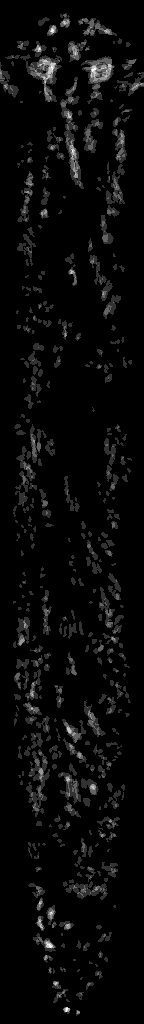

In [ ]:
s = np.zeros((1024, 144))
for i in range(5):
  s += pl[i]['labels'] > 0
cv2_imshow(s * 50)

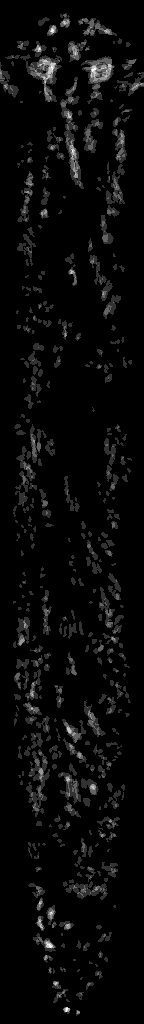

In [ ]:
s = np.zeros((1024, 144))
for i in range(5):
  s += pl[i]['labels'] > 0
cv2_imshow(s * 50)

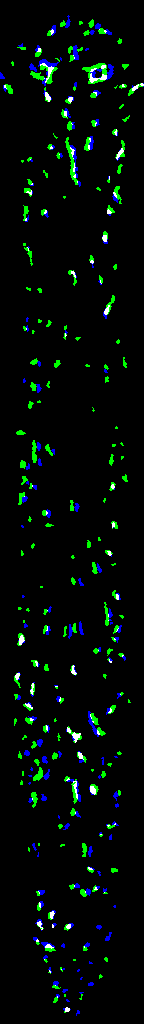

In [ ]:
intersec = np.zeros((1024, 144, 3))
intersec[:,:, 0] = pl[0]['labels'] * 1000
intersec[:,:, 1] = pl[1]['labels'] * 1000
intersec[:,:, 2] = pl[0]['labels'] * pl[1]['labels'] * 1000

cv2_imshow(intersec)

In [ ]:
n1 = 5
n2 = 4
print(len(pl[n1]['cc_names']), len(pl[n2]['cc_names']))

199 161


In [ ]:
dist = np.array([[5] * len(pl[1]['cc_names']) for h in range(len(pl[4]['cc_names']))])
for i in range(len(pl[0]['cc_names'])):
  for j in range(len(pl[1]['cc_names'])):
    c1 = pl[0]['centroids'][i]
    c2 = pl[1]['centroids'][j]
    w1 = pl[0]['labels'][i, cv.CC_STAT_WIDTH]
    w2 = pl[1]['labels'][j, cv.CC_STAT_WIDTH]
    h1 = pl[0]['labels'][i, cv.CC_STAT_HEIGHT]
    h2 = pl[1]['labels'][j, cv.CC_STAT_HEIGHT]
    dist[i][j] = ((c1[0] - c2[0]) ** 2 + 2 *(c1[1] - c2[1]) ** 2) ** 0.5 + abs(w1 - w2) + abs(h1 - h2)

In [ ]:
dist.shape

(161, 201)

In [ ]:
row_ind, col_ind = linear_sum_assignment(dist)

In [ ]:
row_ind, col_ind = col_ind, row_ind

In [ ]:
ans1 = np.zeros((1024, 144, 3))
ans2 = np.zeros((1024, 144, 3))

for i in range(len(row_ind)):
  color = list(np.random.choice(range(256), size=3))
  l1 = pl[5]['cc_names'][row_ind[i]]
  l2 = pl[4]['cc_names'][col_ind[i]]
  ans1[pl[5]['labels'] == l1,:] = color
  ans2[pl[4]['labels'] == l2,:] = color

cv2_imshow(np.concatenate([ans1, ans2], axis=1))

IndexError: ignored

In [ ]:
result = algorithm.find_matching(dist, matching_type = 'min', return_type = 'list' )

In [ ]:
result

[(('21', '118'), 6186.763987441131),
 (('12', '119'), 971.1923076923077),
 (('14', '120'), 1632.28041322314),
 (('7', '117'), 5190.121677812071),
 (('1', '105'), 386.050291072164),
 (('4', '122'), 1558.7659567901235),
 (('5', '121'), 3169.030962682531),
 (('15', '124'), 1698.5408641975305),
 (('18', '115'), 2999.4382716049377),
 (('27', '123'), 100000000.0),
 (('0', '110'), 53.34021050536565),
 (('19', '111'), 17553.25),
 (('6', '109'), 1842.235918367347),
 (('22', '104'), 6574.127258746636),
 (('8', '114'), 50.55348654286789),
 (('10', '100'), 9820.3125),
 (('13', '108'), 534.862577777778),
 (('23', '112'), 20046.2320713237),
 (('20', '101'), 6086.562499999999),
 (('9', '116'), 3821.173076923076),
 (('16', '103'), 15486.209183673469),
 (('25', '126'), 100000000.0),
 (('17', '106'), 889.8694444444445),
 (('3', '127'), 861.6829986149585),
 (('26', '125'), 100000000.0),
 (('24', '102'), 17166.15625),
 (('2', '113'), 1732.7241671917661),
 (('11', '107'), 2384.503673094582)]

In [ ]:
pl[0][0]

[8,
 12,
 13,
 15,
 17,
 18,
 25,
 27,
 28,
 29,
 30,
 31,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 47]

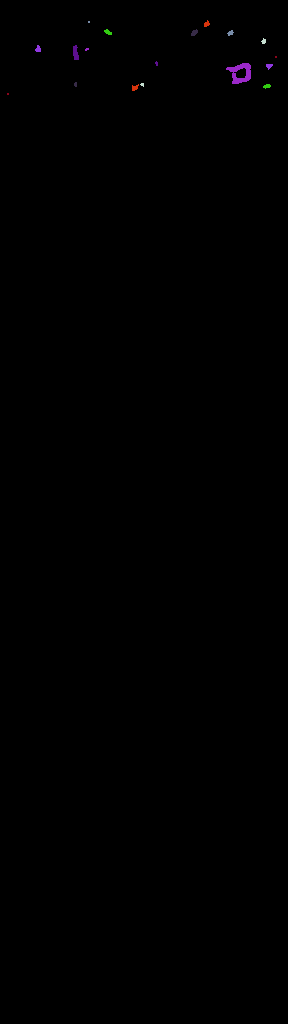

In [ ]:
ans1 = np.zeros((1024, 144, 3))
ans2 = np.zeros((1024, 144, 3))
for (a, b), c in result:
  color = list(np.random.choice(range(256), size=3))
  a = int(a)
  b = int(b) - 100
  if (a >= 25):
    break
  l1 = pl[0][0][a]
  l2 = pl[1][0][b]
  ans1[pl[0][1] == l1, :] = color
  ans2[pl[1][1] == l2, :] = color
cv2_imshow(np.concatenate([ans1, ans2], axis=1))

In [ ]:
algorithm.find_matching(G, matching_type = 'max', return_type = 'list')

In [ ]:
plararia:
  'spots': list of indexes, bounding_boxes
  'body': matrix

In [ ]:
#spot == label
def match_spot(p1, p2):
  for spot in p1['spots']:
    for num_spots in range(0, 3):
      for spot2 in p2['spots']:
        loss =

In [ ]:
сжатие, сортировка по ординате, смотрим окрестности, сравнение попарно, индикация

In [ ]:
res = np.empty((1024, 288))
spots1 = np.empty((1024, 144))
spots2 = np.empty((1024, 144))
stats1 = 0
stats2 = 0
good_cc1 = 0
good_cc2 = 0
for w, texture in enumerate(pl1[:2]):
  img = cv.imread(data_path + texture, cv.IMREAD_UNCHANGED)
  gr_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  background = img[:, :, 3] > 0
  lap_gaus = ndimage.laplace(ndimage.gaussian_filter(gr_img, sigma=2))
  _ = ndimage.gaussian_filter(lap_gaus, sigma=1)
  _, spots = cv.threshold(_, 200 ,255, cv.THRESH_BINARY)

  cc = cv.connectedComponentsWithStats(spots, 8, cv.CV_32S)
  total_cc = cc[0]
  labels = cc[1]
  stats = cc[2]
  centroids = cc[3]

  good_cc = []
  zeros = np.zeros((1024, 144))
  for i in range(total_cc):
    a = (labels == i)
    b = a * background
    if np.array_equal(a, b):
      good_cc.append(i)

  labels_good = np.isin(np.array(labels), np.array(good_cc)) * labels

  if w == 0:
    spots1 = labels_good
    stats1 = cc
    good_cc1 = good_cc
  else:
    spots2 = labels_good
    stats2 = cc
    good_cc2 = good_cc
cv2_imshow(spots1)
cv2_imshow(spots2)

In [ ]:
cnt1 = np.unique(spots1).shape[0]
cnt2 = np.unique(spots2).shape[0]
labels1 = np.unique(spots1)
labels2 = np.unique(spots2)

diss = np.zeros((cnt1, cnt2))

In [ ]:
labels1.shape

(243,)

In [ ]:
for i, l1 in enumerate(labels1):
  for j, l2 in enumerate(labels2):
    cent1 = stats1[3][l1]
    cent2 = stats2[3][l2]
    diss[i, j] = abs(cent1[0] - cent2[0]) ** 2 + abs(cent1[1] - cent2[1]) ** 2
diss

array([[5.94752878e+00, 2.38142663e+05, 2.37567249e+05, ...,
        2.38881353e+05, 2.48673539e+05, 2.50686699e+05],
       [2.41243007e+05, 5.51045980e+02, 2.91646756e+01, ...,
        9.55102681e+05, 9.74897421e+05, 9.78939125e+05],
       [2.42148618e+05, 9.33755102e+00, 6.88768861e+02, ...,
        9.57291211e+05, 9.76626168e+05, 9.80232250e+05],
       ...,
       [2.45869335e+05, 9.72514665e+05, 9.71409056e+05, ...,
        2.18742743e+02, 1.80576989e-01, 1.18695816e+02],
       [2.48900718e+05, 9.78077206e+05, 9.77608111e+05, ...,
        6.58291742e+02, 1.27069763e+02, 6.63265306e-01],
       [2.55751419e+05, 9.91944838e+05, 9.91042158e+05, ...,
        6.03449905e+02, 1.02210069e+02, 1.05250000e+02]])

In [ ]:
arg_mat

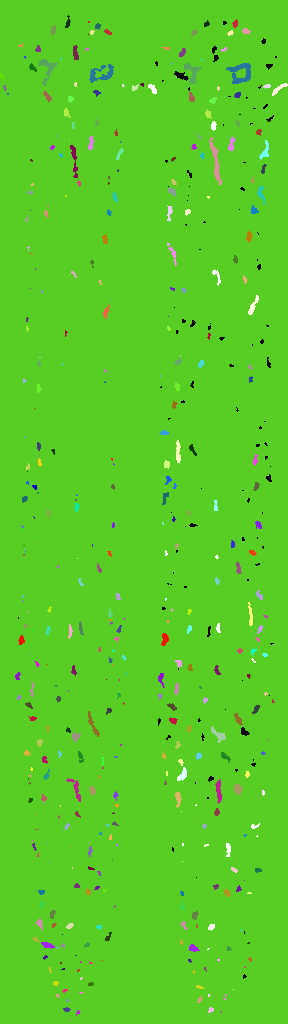

In [ ]:
arg_mat = np.argmin(diss, axis=1)

m1 = np.zeros((1024, 144, 3))
m2 = np.zeros((1024, 144, 3))
for i, j in enumerate(arg_mat):
  color = list(np.random.choice(range(256), size=3))
  a = (spots1 == labels1[i])
  b = np.zeros((1024, 144, 3))
  b[:, :, 0] = a
  b[:, :, 1] = a
  b[:, :, 2] = a
  m1 += b * np.full(shape=(1024, 144, 3), fill_value=color)
  a = (spots2 == labels2[j])
  b = np.zeros((1024, 144, 3))
  b[:, :, 0] = a
  b[:, :, 1] = a
  b[:, :, 2] = a
  m2 += b * np.full(shape=(1024, 144, 3), fill_value=color)
cv2_imshow(np.concatenate([m1, m2], axis=1))

In [ ]:
#Выделение нескольких образцов

### Считывание картинки и преобразование в ч/б

In [ ]:
image = cv.imread('/content/gdrive/MyDrive/Курсовая/textures/02_06_04.png', cv.IMREAD_UNCHANGED)
gr_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
img_a = cv.cvtColor(image ,cv.COLOR_BGRA2BGR)
cv2_imshow(gr_img)

### Выделение подложки

In [ ]:
img1 = image[:, :, 3 ] > 0

### Выделение пятен

In [ ]:
res1 = ndimage.gaussian_filter(gr_img, sigma=1)
res2 = ndimage.laplace(res1)
_, thresh = cv.threshold(res2,200,255,cv.THRESH_BINARY)
cv2_imshow(thresh * img1)

In [ ]:
res3 = ndimage.gaussian_filter(res2, sigma=1)
_, thresh1 = cv.threshold(res3,200,255,cv.THRESH_BINARY)
cv2_imshow(thresh1 * img1)

In [ ]:
res3 = ndimage.binary_opening(thresh, structure=np.ones((2,2)), iterations=2).astype(int)
cv2_imshow(res3 * 255 *img1)

In [ ]:
res4 = cv.morphologyEx(thresh, cv.MORPH_OPEN, (2, 2))
cv2_imshow(res4)

In [ ]:
np.unique(res4)

array([  0, 255], dtype=uint8)

In [ ]:
res5 = cv.morphologyEx(res4, cv.MORPH_OPEN, (5, 5))
cv2_imshow(res5)

### Выделение компонент связности

In [ ]:
ok = thresh1

In [ ]:
np.unique(ok)

array([  0, 255], dtype=uint8)

In [ ]:
cc = cv.connectedComponentsWithStats(thresh1, 8, cv.CV_32S)
print(cc[0])

351


In [ ]:
total_cc = cc[0]
labels = cc[1]
stats = cc[2]
centroids = cc[3]

In [ ]:
np.unique(labels)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
stats[6, cv.CC_STAT_AREA]

4

In [ ]:
stats[1:, cv.CC_STAT_AREA]

array([332,  37,  31,  51,   2,   4,   3,  10,   9,  40,   2,   5,  73,
         2,   3,  79,   5,   9,   7,  13,   5,  36,   2,  37,  21, 273,
         2,   9, 263,   9,   5,   3, 106,   4,  10,  19,   1,  33,  30,
         2, 150, 235,   1, 245,  14,   3,  16,   3,   2,   1,   3,   2,
        10,  75,   4,   1,   1,   4,  11,   1,   7,  62,  50,  12,   1,
        19,  16,   5,   8,  54,  12,   2,  46,  36,  18,  30,   1,  68,
       118,   4,  40,   2,  29,  13,  18,  22,  35,  45,   1,  14,   9,
        26,   8,  22,  11,   1,  30,   2,  24,  25,  39,  12,   8,  27,
        32,  64,  24,   1,   7,   1,  61,  27,  90,  35,  14,  24,  29,
         3,  10,  17,   2,  25,   9,  17,  33,  23,   2,   4,  11,   7,
        10,   9,  21,  25,  12,  24,  25,  36,   1,   1,  21,  19,  16,
        12,   3,  48,   2,  34,   6,  23,   7,  12,  21,  12,   3,  36,
        37,  12,   5,   6,   2,  25,   8,   3,  15,  67,  30,   2,   2,
         1,  20,  12,  13,   7,   5,  11,  20,  12,  38,  22,  2

In [ ]:
s_min = 10
n = 50

args = np.argsort(stats[:, cv.CC_STAT_AREA])
print(args)
sorted_area = np.sort(stats[:, cv.CC_STAT_AREA])



[309 200  60 199  65 195  57 218 170  56  77  50 203 258 281 216 294 140
 139  89  37  43 110 108  96 348 213  52 210  72 191 169 168 161  82 147
 325 127 121 334 219  49  98  14 271 345 268  40  11  23 263 300  27 255
 256 226 305 251   5 145 155 272 304  46 190 303 192  48  15 118 260  51
  32 164 302   7 208 198 128   6 222  58  34 328 337  55 254  80 265 343
 184 276 277 205 264 194 249 248 159 175  68  12  17  31  21 149 228 197
 209 230 288 160  19 151 183  61 287 174 130 109 314 239  93 344  69 103
 163 232 338 253  91 299 123 132 229 257  30  28   9  18   8 119  35  53
 319 131 286 241 129 176  95 206  59 202 261  64 178 315  71 243 154 172
 246 102 135 279 144 152 158 217  84 173  20  90 340  45 115 165 221 244
 193 215 240 242 262 307 320  47  67 143 290 224 310 259 124 120 223 295
 284 280 186 189 336  75 332  85 342 266 273  66 301  36 142 171 270 177
 201 187 324 185 312 153 235 133 141 317  25 321  86 180 238 329  94 339
 126 292 150 225 107  99 116 136 341 181 252 267 10

In [ ]:
labels_50 = labels.copy()
for i in range(total_cc - n - 1):
  labels_50[labels_50 == (args[i])] = 0

In [ ]:
new_cc = np.unique(labels_50)

In [ ]:
col_cc = np.zeros((1024, 144, 3))
for i in list(new_cc):
  color = list(np.random.choice(range(256), size=3))
  a = (labels_50 == i)
  b = np.zeros((1024, 144, 3))
  b[:, :, 0] = a
  b[:, :, 1] = a
  b[:, :, 2] = a
  col_cc += b * np.full(shape=(1024, 144, 3), fill_value=color)

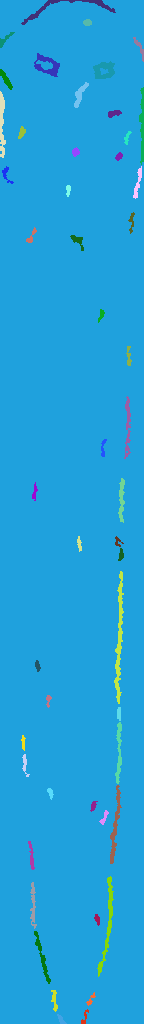

In [ ]:
cv2_imshow(col_cc)

In [ ]:
#Выделение компонент, не лежащих на границе
good_cc = []
zeros = np.zeros((1024, 144))
for i in range(total_cc):
  a = (labels == i)
  b = a * img1
  if np.array_equal(a, b):
    good_cc.append(i)
print(good_cc)

[2, 3, 4, 6, 9, 12, 15, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 97, 99, 101, 103, 104, 105, 107, 108, 110, 111, 112, 113, 116, 117, 118, 121, 122, 124, 125, 128, 129, 131, 132, 133, 135, 137, 138, 140, 141, 144, 146, 150, 151, 153, 154, 156, 158, 160, 162, 164, 167, 170, 172, 175, 177, 181, 183, 184, 185, 187, 189, 192, 194, 195, 196, 197, 198, 199, 200, 201, 203, 204, 205, 209, 211, 214, 217, 220, 221, 224, 225, 228, 229, 231, 232, 233, 238, 239, 240, 242, 243, 245, 248, 250, 252, 254, 256, 257, 258, 259, 263, 264, 266, 267, 268, 269, 271, 272, 274, 276, 277, 278, 280, 281, 282, 283, 285, 286, 287, 290, 291, 293, 294, 295, 299, 300, 301, 302, 303, 305, 307, 308, 312, 313, 314, 316, 318, 323, 324, 325, 329, 332, 333, 334, 336, 337, 338, 339, 340, 341, 34

In [ ]:
len(good_cc)

218

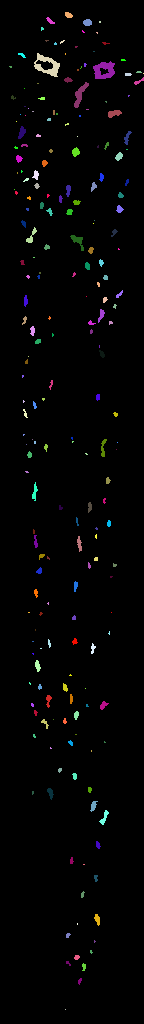

In [ ]:
#визуализация только внутренних компонент
col_cc = np.zeros((1024, 144, 3))
for i in good_cc:
  color = list(np.random.choice(range(256), size=3))
  a = (cc[1] == i)
  b = np.zeros((1024, 144, 3))
  b[:, :, 0] = a
  b[:, :, 1] = a
  b[:, :, 2] = a
  col_cc += b * np.full(shape=(1024, 144, 3), fill_value=color)

cv2_imshow(col_cc)

In [ ]:
#оставляем в labels только хорошие
labels_good = labels.copy()
for i in range(labels.shape[0]):
  for j in range(labels.shape[1]):
    if not(labels[i][j] in good_cc):
      labels[i][j] = 0

In [ ]:
#выделение больших компонент среди хороших
areas = stats[good_cc, cv.CC_STAT_AREA]
args = np.argsort(areas)
sorted_areas = np.sort(areas)


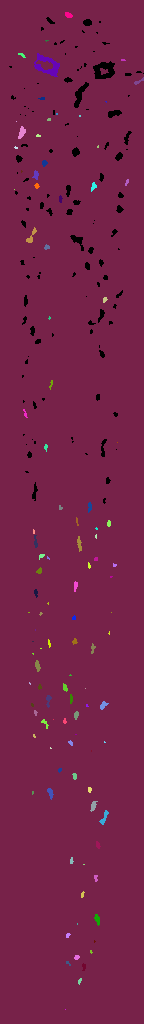

In [ ]:
labels_50 = labels_good.copy()
for i in range(len(good_cc) - 50):
  labels_50[labels_50 == (args[i])] = 0

new_cc = np.unique(labels_50.astype(int))
col_cc = np.zeros((1024, 144, 3))
for i in new_cc:
  color = list(np.random.choice(range(256), size=3))
  a = (cc[1] == i)
  b = np.zeros((1024, 144, 3))
  b[:, :, 0] = a
  b[:, :, 1] = a
  b[:, :, 2] = a
  col_cc += b * np.full(shape=(1024, 144, 3), fill_value=color)
cv2_imshow(col_cc)

In [ ]:
col_cc = np.zeros((1024, 144, 3))
for i in range(1, cc[0]):
  color = list(np.random.choice(range(256), size=3))
  a = (cc[1] == i)
  b = np.zeros((1024, 144, 3))
  b[:, :, 0] = a
  b[:, :, 1] = a
  b[:, :, 2] = a
  col_cc += b * np.full(shape=(1024, 144, 3), fill_value=color)

In [ ]:
b = np.zeros((1024, 144, 3))
b[:, :, 0] = img1
b[:, :, 1] = img1
b[:, :, 2] = img1

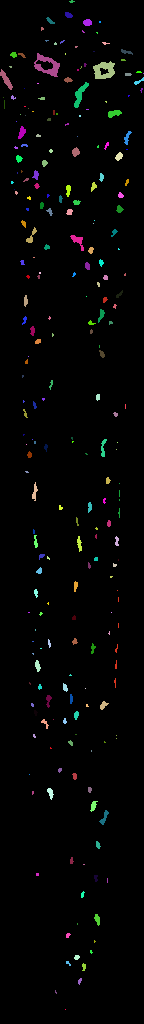

In [ ]:
cv2_imshow(col_cc * b)

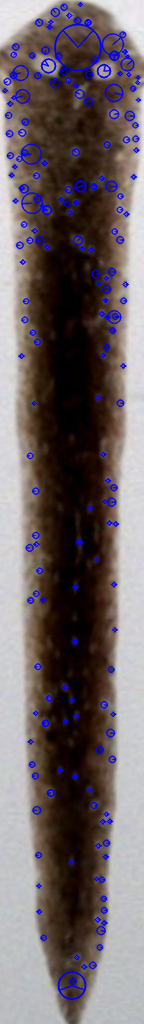

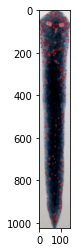

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
img = cv.imread('03_00_05.png')
surf = cv.xfeatures2d.SIFT_create(400)
kp, des = surf.detectAndCompute(img,None)
# We set it to som
#e 50000. Remember, it is just for representing in picture.
# In actual cases, it is better to have a value 300-500
# Again compute keypoints and check its number.
kp, des = surf.detectAndCompute(img,None)
img2 = cv.drawKeypoints(img,kp,None,(255,0,0),4)
plt.imshow(img2)
cv2_imshow(img2)
#plt.savefig("aa.pdf")
#plt.show()

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from scipy import ndimage
import scipy

In [ ]:
image = cv.imread('03_00_05.png', cv.IMREAD_UNCHANGED)
gr_img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
img_a = cv.cvtColor(image ,cv.COLOR_BGRA2BGR)


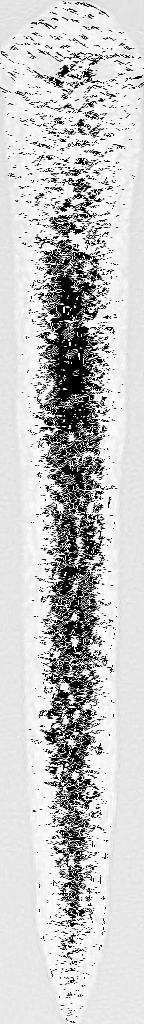

In [ ]:
result = ndimage.gaussian_laplace(gr_img, sigma=0.6)
cv2_imshow(result)

In [ ]:
LoG = ndimage.gaussian_laplace(gr_img , 5)
thres = np.absolute(LoG).mean() * 0.75
output = np.zeros(LoG.shape)
w = output.shape[1]
h = output.shape[0]
for y in range(1, h - 1):
    for x in range(1, w - 1):
        patch = LoG[y-1:y+2, x-1:x+2]
        p = LoG[y, x]
        maxP = patch.max()
        minP = patch.min()
        if (p > 0):
            zeroCross = True if minP < 0 else False
        else:
            zeroCross = True if maxP > 0 else False
        if ((maxP - minP) > thres) and zeroCross:
            output[y, x] = 1


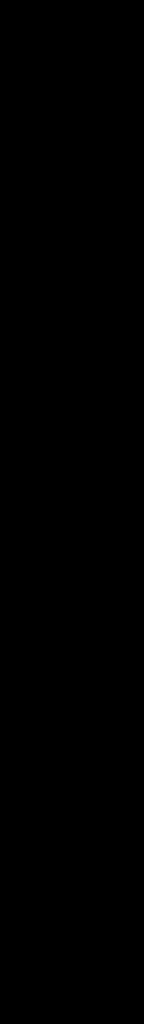

In [ ]:
cv2_imshow(output.astype(np.uint8) *255)

In [ ]:
ret, img = cv.threshold(gr_img, 127, 255, cv.THRESH_BINARY)

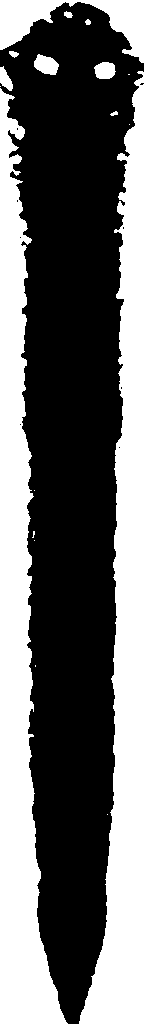

In [ ]:
cv2_imshow(img)

In [ ]:
from scipy import ndimage

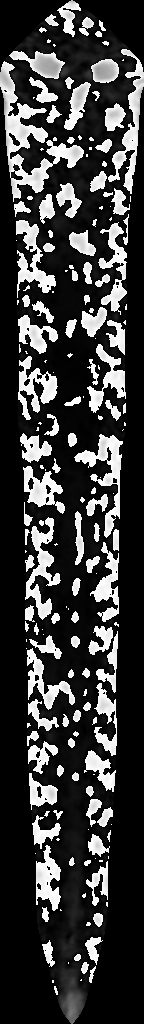

In [ ]:
result1 = ndimage.median_filter(gr_img, size=60)
result2 = ndimage.median_filter(gr_img, size=2)
result = result1 - result2
cv2_imshow(result * img1)

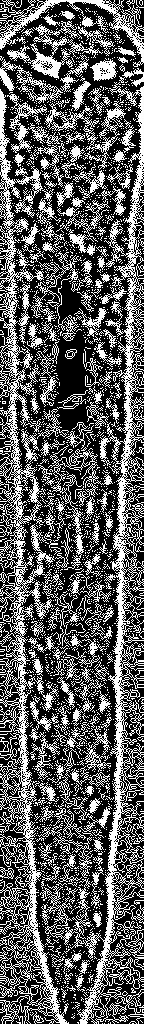

In [ ]:
res = ndimage.laplace(res1)
cv2_imshow(res)

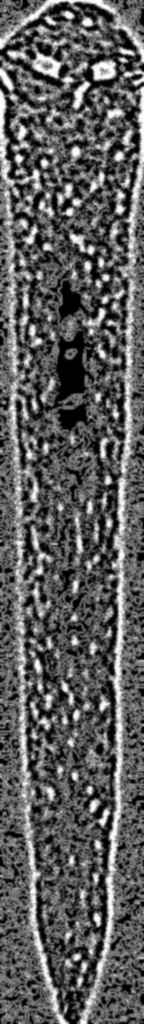

In [ ]:
res2 = ndimage.gaussian_filter(res, sigma=1)
cv2_imshow(res2)

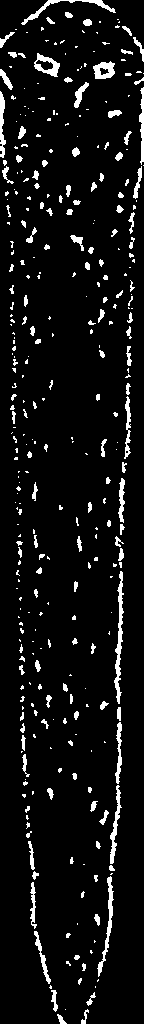

In [ ]:
_, thresh = cv.threshold(res2,200,255,cv.THRESH_BINARY)
cv2_imshow(thresh)

In [ ]:
np.unique(cv.connectedComponentsWithStats(thresh, 8, cv.CV_32S)[1])


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
cv2_imshow(cv.connectedComponentsWithStats(res2)[1])

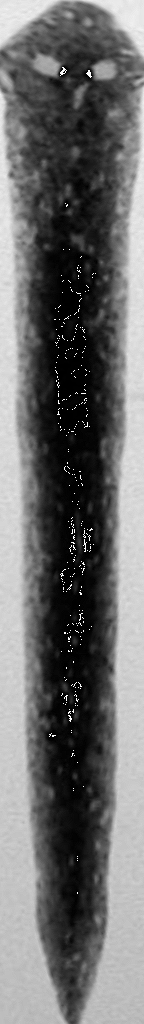

In [ ]:
cv2_imshow(gr_img - res)

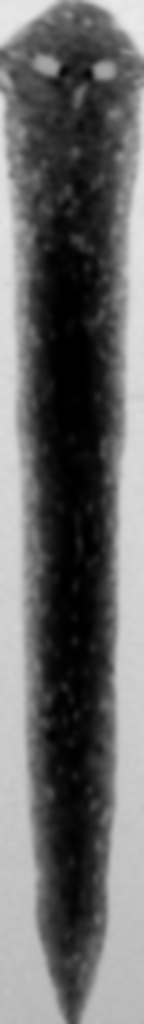

In [ ]:
res1 = ndimage.gaussian_filter(gr_img, sigma=2)
cv2_imshow(res1)

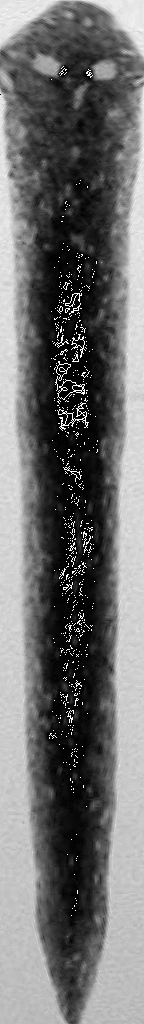

In [ ]:
cv2_imshow(gr_img - res)

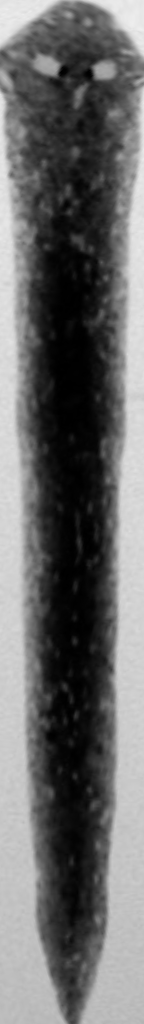

In [ ]:
cv2_imshow(gr_img)

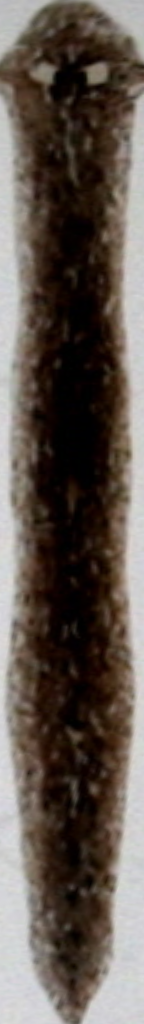

In [ ]:
cv2_imshow(img_a)

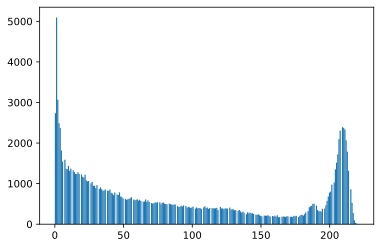

In [ ]:
plt.hist(gr_img.ravel(), bins = 256)
plt.show()

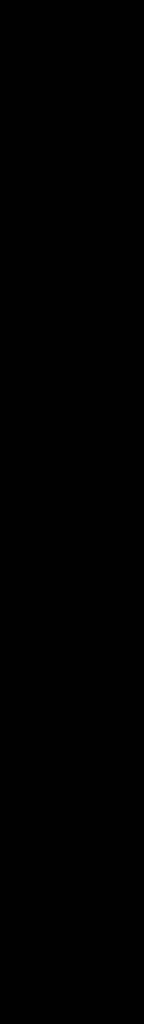

In [ ]:
#выделение фона
img1 = np.empty(shape=(1024, 144))
for i in range(gr_img.shape[0]):
    for j in range(gr_img.shape[1]):
        if image[i, j, 3] > 0:
            img1[i, j] = 1
        else:
            img1[i, j] = 0
cv2_imshow(img1)

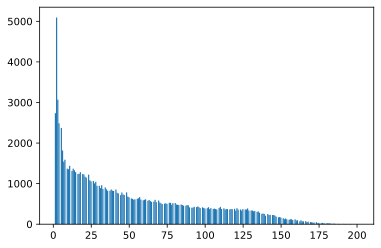

In [ ]:
plt.hist(img1.ravel()[img1.ravel() > 0], bins = 256)
plt.show()

In [ ]:

img1 = np.empty(shape=(1024, 144, 3))
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        if image[i, j, 3] > 0:
            img1[i, j, 0] = 255;image[i, j, 0]
            img1[i, j, 1] = 255;image[i, j, 1]
            img1[i, j, 2] = 255;image[i, j, 2]
        else:
            im[i, j, 0] = 0
            im[i, j, 1] = 0
            im[i, j, 2] = 0
        #print(img1[i, j, 0], img1[i, j, 1], img1[i, j, 2], img1[i, j, 3])
img2 = np.empty(shape=(1024, 144))
img2 = image[:, :, 3]
cv2.imshow('B', im)
#_ = plt.hist(image.ravel(), bins = 256, color = 'orange', )
ret, img = cv2.threshold(image, 46, 255, cv2.THRESH_BINARY)
#cv2.imshow('A', img)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
%config InlineBackend.figure_format = 'svg'
